In [2]:
# imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import spacy
from collections import Counter

# load spaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# stopwords
STOPWORDS = set(stopwords.words("english"))

# path to the dataset
DATA_PATH = Path("../data/raw/Umuzi XB1 Check in (Responses) - Form Responses 1.xlsx")

DATA_PATH.exists()


True

In [3]:
# load and inspect
xl = pd.ExcelFile(DATA_PATH)
print("Sheets:", xl.sheet_names)

df = xl.parse(xl.sheet_names[0])
df.head(5)


Sheets: ['Copy of Umuzi XB1 Check in (Res']


,Timestamp,Column 2,Full name,Please enter the date today,"Share a win from the last week (what went well, something you enjoyed)",Share a loss (something that was challenging or did not go well),"Share a blocker, if any (anything that stopped you from doing what you needed to do)",Anything else you would like to share or ask
0,2025-07-09 14:34:49,NaN,Student 1,2025-07-09 00:00:00,Completing my first week with Umuzi gave me co...,I didn’t get opportunities from two companies ...,Being financially unstable has been draining m...,I appreciate Umuzi for this opportunity to sho...
1,2025-07-09 14:43:15,NaN,Student 2,2025-07-09 00:00:00,I enjoyed introspecting myself on the basis of...,Except for being sick and experiencing challen...,"None, only temporary set backs (reception and ...",Nothing for now.
2,2025-07-09 14:49:40,NaN,Student 3,2025-07-09 00:00:00,Submitting all my work in time and completing ...,I don’t have any,"Data , I couldn’t join some meetings because I...",No thank you
3,2025-07-09 14:50:41,NaN,Student 4,2025-07-09 00:00:00,I submitted most of the assigned assignments,I did not understand some assignments s well a...,Spending most time in class leading to having ...,"In overall, I am doing well and trying to do a..."
4,2025-07-09 15:14:46,NaN,Student 5,2025-07-09 00:00:00,I enjoyed the Life Lifeline activity. I got to...,NaN,"I forgot to login to Google classroom, until I...",No.


In [4]:
# checking column names
print("Columns:", list(df.columns))
df.info()
# num of rows
print(f"\nTotal rows: {len(df)}")


Columns: ['Timestamp', 'Column 2', 'Full name', 'Please enter the date today', 'Share a win from the last week (what went well, something you enjoyed)', 'Share a loss (something that was challenging or did not go well)', 'Share a blocker, if any (anything that stopped you from doing what you needed to do)', 'Anything else you would like to share or ask']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 8 columns):
 #   Column                                                                                Non-Null Count  Dtype         
---  ------                                                                                --------------  -----         
 0   Timestamp                                                                             372 non-null    datetime64[ns]
 1   Column 2                                                                              0 non-null      float64       
 2   Full name                                     

In [5]:
# Simplifying column names and preview text
text_cols = [
    'Share a win from the last week (what went well, something you enjoyed)',
    'Share a loss (something that was challenging or did not go well)',
    'Share a blocker, if any (anything that stopped you from doing what you needed to do)'
]

# Renaming for easier handling
df_raw = df.rename(columns={
    'Share a win from the last week (what went well, something you enjoyed)': 'Win',
    'Share a loss (something that was challenging or did not go well)': 'Loss',
    'Share a blocker, if any (anything that stopped you from doing what you needed to do)': 'Blocker'
})

# new text_cols  names
text_cols = ['Win', 'Loss', 'Blocker']

# Show missing counts
print("Missing values per column:")
missing = df_raw[text_cols].isnull().sum()
print(missing)
print(f"\nMissing percentages:")
print((missing / len(df_raw) * 100).round(2))

# Preview sample text from each column
print("\n" + "="*80)
print("SAMPLE WIN RESPONSES (first 5):")
print("="*80)
for i, text in enumerate(df_raw['Win'].dropna().head(5), 1):
    print(f"{i}. {text[:150]}...")

print("\n" + "="*80)
print("SAMPLE LOSS RESPONSES (first 5):")
print("="*80)
for i, text in enumerate(df_raw['Loss'].dropna().head(5), 1):
    print(f"{i}. {text[:150]}...")

print("\n" + "="*80)
print("SAMPLE BLOCKER RESPONSES (first 5):")
print("="*80)
for i, text in enumerate(df_raw['Blocker'].dropna().head(5), 1):
    print(f"{i}. {text[:150]}...")

Missing values per column:
Win        12
Loss       69
Blocker    95
dtype: int64

Missing percentages:
Win         3.23
Loss       18.55
Blocker    25.54
dtype: float64

SAMPLE WIN RESPONSES (first 5):
1. Completing my first week with Umuzi gave me confidence and a sense of purpose. I especially enjoyed the design thinking and Odyssey Plan exercises, wh...
2. I enjoyed introspecting myself on the basis of building those prototypes and 5 lives, as much as they were not real they ignited me to think of my pur...
3. Submitting all my work in time and completing my Courses...
4. I submitted most of the assigned assignments...
5. I enjoyed the Life Lifeline activity. I got to dig deep and ask myself difficult questions and be honest with myself....

SAMPLE LOSS RESPONSES (first 5):
1. I didn’t get opportunities from two companies that interviewed me last month, which was discouraging. However, I learned from the experience and was g...
2. Except for being sick and experiencing challenges w

In [6]:
import nltk
import ssl

# Fix SSL certificate issues
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
print("NLTK download complete.")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...


NLTK download complete.


[nltk_data]   Package omw-1.4 is already up-to-date!


In [7]:
# missing values fill and text cleaning function
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words("english"))

# stopwords
domain_stopwords = {
    "umuzi", "class", "today", "week", "student", "last", "went", "well",
    "none", "na", "n/a", "nothing", "blocker", "loss", "win", "share"
}
STOPWORDS.update(domain_stopwords)

def clean_text(text):
    """Clean and preprocess text for NLP analysis"""
    if not isinstance(text, str) or text.strip() == "":
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove URLs and emails
    text = re.sub(r'http\S+|www\S+|@\S+', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', ' ', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2]
    
    # Lemmatize using spaCy
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    
    return " ".join(lemmas)

# Fill missing values with empty strings
print("Filling missing values...")
df_raw[text_cols] = df_raw[text_cols].fillna("")
print("Missing values filled with empty strings")

# cleaning function test
print("\n" + "="*80)
print("CLEANING FUNCTION TEST")
print("="*80)
test_text = "I didn't get opportunities from two companies that interviewed me last month, which was discouraging."
print(f"Original: {test_text}")
print(f"Cleaned:  {clean_text(test_text)}")

print("\n" + "="*80)
test_text2 = "Data , I couldn't join some meetings because I was out of data"
print(f"Original: {test_text2}")
print(f"Cleaned:  {clean_text(test_text2)}")

print("\nText cleaning function ready!")

Filling missing values...
Missing values filled with empty strings

CLEANING FUNCTION TEST
Original: I didn't get opportunities from two companies that interviewed me last month, which was discouraging.
Cleaned:  get opportunity two company interview month discouraging

Original: Data , I couldn't join some meetings because I was out of data
Cleaned:  datum join meeting datum

Text cleaning function ready!


In [8]:
# Cleaning Win/Loss/Blocker columns

print("Applying text cleaning to all text columns...")

for col in text_cols:
    clean_col = col + "_clean"
    df_raw[clean_col] = df_raw[col].apply(clean_text)

print("Cleaning complete!")

# preview cleaned outputs
df_raw[['Win', 'Win_clean', 'Loss', 'Loss_clean', 'Blocker', 'Blocker_clean']].head(10)


Applying text cleaning to all text columns...
Cleaning complete!


,Win,Win_clean,Loss,Loss_clean,Blocker,Blocker_clean
0,Completing my first week with Umuzi gave me co...,complete first give confidence sense purpose e...,I didn’t get opportunities from two companies ...,get opportunity two company interview month di...,Being financially unstable has been draining m...,financially unstable drain energy focus day se...
1,I enjoyed introspecting myself on the basis of...,enjoy introspect basis building prototype live...,Except for being sick and experiencing challen...,except sick experiencing challenge reception n...,"None, only temporary set backs (reception and ...",temporary set back reception etc
2,Submitting all my work in time and completing ...,submit work time complete course,I don’t have any,,"Data , I couldn’t join some meetings because I...",datum join meeting datum
3,I submitted most of the assigned assignments,submit assign assignment,I did not understand some assignments s well a...,understand assignment feel like lot work atten...,Spending most time in class leading to having ...,spend time lead little time understand execute...
4,I enjoyed the Life Lifeline activity. I got to...,enjoy life lifeline activity get dig deep ask ...,,,"I forgot to login to Google classroom, until I...",forget login google classroom receive email na...
5,I enjoyed and learnt from the design your life...,enjoy learn design life module able think deep...,,,I ran out of data which made me miss some sess...,run datum make miss session
6,What went well was hearing other candidates pl...,hear candidate plan year odyssey enjoy inspire...,I would say I struggled a bit or was confused ...,would say struggle bit confused one symbol sup...,I would say not reading instructions sometimes...,would say read instruction sometimes back fix ...
7,I enjoyed sharing my symbol and it's meaning.,enjoy share symbol mean,I submitted 2 of my tasks late last week.,submit task late,There is a power failure affecting a few house...,power failure affect house neighbourhood unfor...
8,"It was a good week, I learnt a lot about mysel...",good learn lot dyl segment eye opening really ...,,,"Nothing hectic, just network issues.",hectic network issue
9,"Although I couldn't submit on time, the tasks ...",although submit time task really enjoyable tea...,I was not able to submit last week work on time,able submit work time,I didn't have much time on my hands since I wa...,much time hand since bless baby recently mom a...


In [9]:
# Top token frequencies for each column

from collections import Counter

def top_n_tokens(series, n=20):
    all_text = " ".join(series.dropna().astype(str))
    tokens = all_text.split()
    return Counter(tokens).most_common(n)

for col in text_cols:
    clean_col = col + "_clean"
    print("="*80)
    print(f"TOP TOKENS FOR: {col.upper()}")
    print("="*80)
    top_tokens = top_n_tokens(df_raw[clean_col], n=20)
    for token, count in top_tokens:
        print(f"{token:20}  {count}")
    print("\n")


TOP TOKENS FOR: WIN
enjoy                 97
learn                 62
complete              52
manage                46
course                45
get                   43
work                  42
plan                  41
time                  39
life                  38
really                38
task                  30
make                  29
able                  28
project               25
odyssey               23
lot                   21
feel                  21
submit                20
think                 19


TOP TOKENS FOR: LOSS
time                  64
work                  46
challenge             39
get                   33
plan                  25
everything            24
struggle              23
able                  22
could                 22
miss                  21
bit                   20
management            19
manage                19
due                   18
complete              18
submit                17
task                  17
make                  17
one    

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Load mini model for speed + accuracy
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Function to train BERTopic on one column
def build_topics(text_series, column_name):
    print(f"\n======================================")
    print(f"BUILDING TOPIC MODEL FOR: {column_name.upper()}")
    print(f"======================================")

    # Filter empty responses
    docs = [t for t in text_series if isinstance(t, str) and len(t.strip()) > 0]

    # Initialize model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        verbose=True,
        min_topic_size=8  
    )

    topics, probs = topic_model.fit_transform(docs)

    # Show top 10 topics
    print("\nTOPIC SUMMARY:")
    topic_info = topic_model.get_topic_info()
    display(topic_info.head(10))

    return topic_model, docs, topics, probs


# Build BERTopic models separately for each category
win_model, win_docs, win_topics, win_probs = build_topics(df_raw["Win_clean"], "Win")
loss_model, loss_docs, loss_topics, loss_probs = build_topics(df_raw["Loss_clean"], "Loss")
blocker_model, blocker_docs, blocker_topics, blocker_probs = build_topics(df_raw["Blocker_clean"], "Blocker")

print("\n=========================")
print("BERTopic models complete!")
print("=========================")


c:\Users\lenovo\umuzi-checkin-nlp\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
2025-11-23 08:35:12,966 - BERTopic - Embedding - Transforming documents to embeddings.



BUILDING TOPIC MODEL FOR: WIN


Batches: 100%|██████████| 12/12 [00:01<00:00,  7.78it/s]
2025-11-23 08:35:14,527 - BERTopic - Embedding - Completed ✓
2025-11-23 08:35:14,528 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 08:35:30,075 - BERTopic - Dimensionality - Completed ✓
2025-11-23 08:35:30,078 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 08:35:30,123 - BERTopic - Cluster - Completed ✓
2025-11-23 08:35:30,135 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-23 08:35:30,178 - BERTopic - Representation - Completed ✓



TOPIC SUMMARY:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,17,-1_exam_certificate_test_complete,"[exam, certificate, test, complete, able, happ...","[able submit work study exam, achieve high mar..."
1,0,269,0_enjoy_plan_life_time,"[enjoy, plan, life, time, manage, work, learn,...","[manage complete work time, enjoy work team su..."
2,1,29,1_money_financial_learn_finance,"[money, financial, learn, finance, save, cours...",[enjoy wealth course keep learn new thing even...
3,2,16,2_datacamp_datum_science_complete,"[datacamp, datum, science, complete, earn, cer...",[manage complete datum clean exploratory analy...
4,3,13,3_customer_course_centricity_business,"[customer, course, centricity, business, centr...","[complete customer centric course, successfull..."
5,4,10,4_coursera_course_complete_wealty,"[coursera, course, complete, wealty, specific,...","[complete course coursera, complete coursera c..."


2025-11-23 08:35:30,226 - BERTopic - Embedding - Transforming documents to embeddings.



BUILDING TOPIC MODEL FOR: LOSS


Batches: 100%|██████████| 9/9 [00:01<00:00,  7.76it/s]
2025-11-23 08:35:31,403 - BERTopic - Embedding - Completed ✓
2025-11-23 08:35:31,404 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 08:35:31,812 - BERTopic - Dimensionality - Completed ✓
2025-11-23 08:35:31,815 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 08:35:31,844 - BERTopic - Cluster - Completed ✓
2025-11-23 08:35:31,850 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-23 08:35:31,881 - BERTopic - Representation - Completed ✓



TOPIC SUMMARY:


,Topic,Count,Name,Representation,Representative_Docs
0,0,259,0_time_work_challenge_get,"[time, work, challenge, get, plan, struggle, c...",[something really challenging time management ...
1,1,27,1_everything_gig_particular_go,"[everything, gig, particular, go, much, comple...","[everything, everything, everything]"


2025-11-23 08:35:31,927 - BERTopic - Embedding - Transforming documents to embeddings.



BUILDING TOPIC MODEL FOR: BLOCKER


Batches: 100%|██████████| 8/8 [00:01<00:00,  7.69it/s]
2025-11-23 08:35:32,982 - BERTopic - Embedding - Completed ✓
2025-11-23 08:35:32,985 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-23 08:35:33,346 - BERTopic - Dimensionality - Completed ✓
2025-11-23 08:35:33,349 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-23 08:35:33,376 - BERTopic - Cluster - Completed ✓
2025-11-23 08:35:33,384 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-23 08:35:33,440 - BERTopic - Representation - Completed ✓



TOPIC SUMMARY:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,94,-1_work_time_meeting_challenge,"[work, time, meeting, challenge, class, able, ...",[balance mom time attend google meeting comple...
1,0,32,0_time_management_task_plan,"[time, management, task, plan, complete, stay,...",[struggle priority task sometimes spend much t...
2,1,26,1_network_issue_connection_internet,"[network, issue, connection, internet, bad, re...",[network side slow sometimes whole day connect...
3,2,25,2_electricity_power_laptop_outage,"[electricity, power, laptop, outage, area, rep...","[electricity work, power outage, power outage ..."
4,3,17,3_test_study_exam_prepare,"[test, study, exam, prepare, write, difficult,...",[feeling also prepare semester test make diffi...
5,4,14,4_fatigue_regular_exhaustion_overwhelm,"[fatigue, regular, exhaustion, overwhelm, gym,...","[fatigue, fatigue lead tired miss regular gym ..."
6,5,13,5_datum_join_lack_enough,"[datum, join, lack, enough, session, training,...","[datum, datum, datum]"
7,6,13,6_sick_really_sickness_flu,"[sick, really, sickness, flu, get, different, ...","[sick, sick, sick]"
8,7,12,7_far_everything_much_currently,"[far, everything, much, currently, hehe, love,...","[far, everything smoothly, thus far]"
9,8,10,8_access_financial_foundation_course,"[access, financial, foundation, course, able, ...","[able access financial course, unable access f..."



BERTopic models complete!


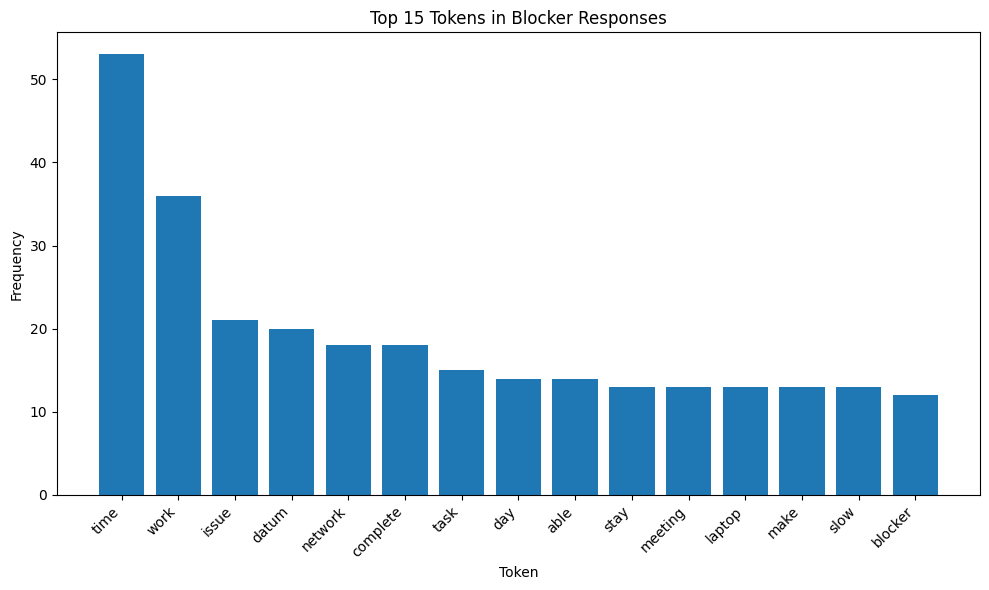

In [ ]:
# Bar chart of top tokens for Blocker

from collections import Counter
import matplotlib.pyplot as plt

# Get top tokens for Blocker_clean
blocker_tokens = " ".join(df_raw["Blocker_clean"]).split()
token_counts = Counter(blocker_tokens).most_common(15)

tokens = [tok for tok, count in token_counts]
counts = [count for tok, count in token_counts]

plt.figure(figsize=(10, 6))
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Tokens in Blocker Responses")
plt.ylabel("Frequency")
plt.xlabel("Token")
plt.tight_layout()
plt.show()


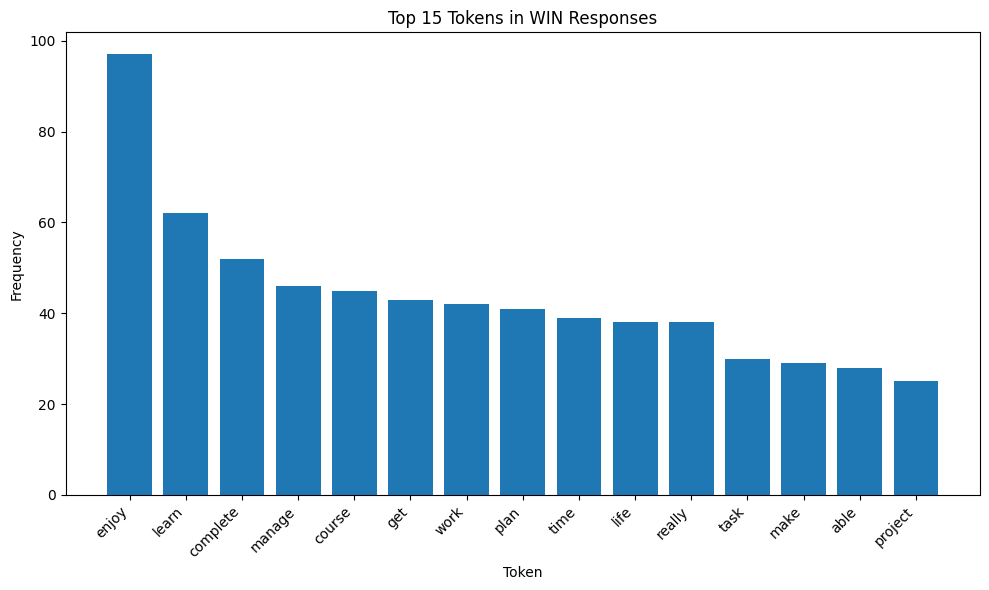

In [12]:
# Visualization: Top tokens for WIN responses

from collections import Counter
import matplotlib.pyplot as plt

# Get top tokens for Win_clean
win_tokens = " ".join(df_raw["Win_clean"]).split()
token_counts = Counter(win_tokens).most_common(15)

tokens = [tok for tok, count in token_counts]
counts = [count for tok, count in token_counts]

plt.figure(figsize=(10, 6))
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top 15 Tokens in WIN Responses")
plt.ylabel("Frequency")
plt.xlabel("Token")
plt.tight_layout()
plt.show()


In [ ]:
# Save cleaned dataset

OUTPUT_PATH = Path("../data/processed/cleaned_checkin_data.csv")


OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

df_raw.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")

print(f"Cleaned dataset saved successfully to:\n{OUTPUT_PATH}")


Cleaned dataset saved successfully to:
..\data\processed\cleaned_checkin_data.csv
